<a href="https://colab.research.google.com/github/andrewcxjin/aipi590-xai/blob/main/human-ai/human_ai_interaction_lime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Human-AI Interaction - LIME Models**

**Andrew Jin**

This notebook provides a code tutorial on how to use LIME to explain the predictions of a black box ML model. The example used will be Inception-v3, an image classification model. We will be using an image that contains a leopard and cheetah, two animals that have similar features, to see what prediction the model makes.

#### 📝 Note

No AI was used in the making of this notebook. I had an assignment on LIME in one of my undergraduate classes, so I referenced to the notebook I created for that assignment when creating this notebook.


## Code Tutorial

In [ ]:
!pip install lime

In [3]:
# Import packages
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries

We will be using Inception-v3 which is a CNN model developed by Google for image classification tasks.

In [4]:
# Load inception v3
inet_model = inc_net.InceptionV3()

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


We will be using an image that contains a leopard and cheetah.

In [ ]:
# Upload image
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [6]:
# Preprocess image data
def preprocess_img(img_path):
  img = image.load_img(img_path, target_size=(299, 299))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = inc_net.preprocess_input(x)
  return x

Let's visualize the image first.

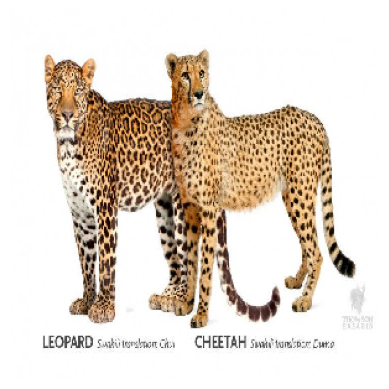

In [7]:
# Data preprocessing and visualization
img_path = 'leopard_cheetah.jpg'
processed_img = preprocess_img(img_path)
plt.imshow(processed_img[0] / 2 + 0.5)
plt.axis('off')
plt.show()

Let's see the top predictions the model makes.

In [8]:
# Model predictions
pred = inet_model.predict(processed_img)
pred_class = decode_predictions(pred, top=5)

print("Top five predictions")
for i in range(5):
  print(f'{pred_class[0][i][1]}: {pred_class[0][i][2]*100:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Top five predictions
cheetah: 62.39%
leopard: 20.14%
jaguar: 0.97%
gazelle: 0.12%
lion: 0.11%


Next, let's use the image explainer from LIME to see the key features of the image it used to generate the predictions.

In [10]:
# Define explainer
explainer = lime_image.LimeImageExplainer()

# Generate explanation of the image
explanation = explainer.explain_instance(image=processed_img[0], classifier_fn=inet_model.predict, top_labels=5, hide_color=0, num_samples=100)

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


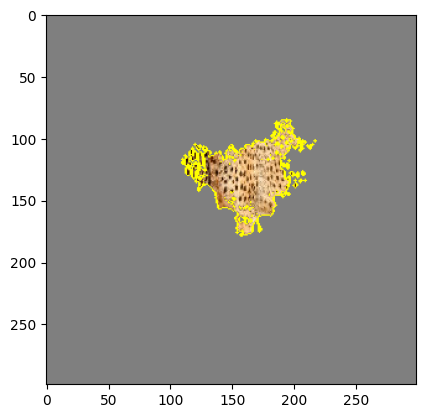

In [11]:
# Visualize feature contributions for top prediction
temp, mask = explanation.get_image_and_mask(label=explanation.top_labels[0],
                                            positive_only=True,
                                            num_features=1,
                                            hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

We can see that top features the model used to make it's top prediction. Next, we will play around with the 'num_features' parameter where we can change the number of pixels to include in the explanations. We will play around with the parameters for the top two predictions of cheetah and leopard to see if and where the model differentiates between the features of the two animals.

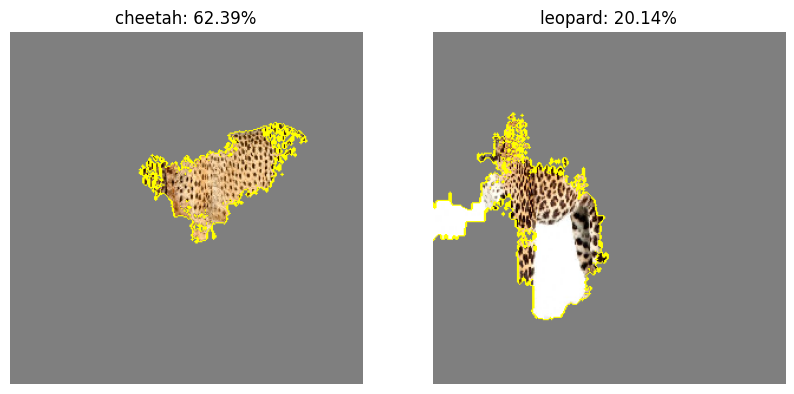

In [12]:
# Visualize selected features for top 2 predictions
temp1, mask1 = explanation.get_image_and_mask(label=explanation.top_labels[0],
                                            positive_only=True,
                                            num_features=2,
                                            hide_rest=True)
temp2, mask2 = explanation.get_image_and_mask(label=explanation.top_labels[1],
                                            positive_only=True,
                                            num_features=2,
                                            hide_rest=True)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(mark_boundaries(temp1 / 2 + 0.5, mask1))
axs[0].set_title(f'{pred_class[0][0][1]}: {pred_class[0][0][2]*100:.2f}%')
axs[0].axis('off')
axs[1].imshow(mark_boundaries(temp2 / 2 + 0.5, mask2))
axs[1].set_title(f'{pred_class[0][1][1]}: {pred_class[0][1][2]*100:.2f}%')
axs[1].axis('off')
plt.show()

From the images, we can see that the model mainly relies on the spot pattern to differentiate between both animals. We can see that a hyperparameter of 2 is the ideal number for visualization. If we use a number higher than this, then we start to see the model including features from the other animal.

For the top predictions, we can use a heatmap to visualize the weights of each pixel.

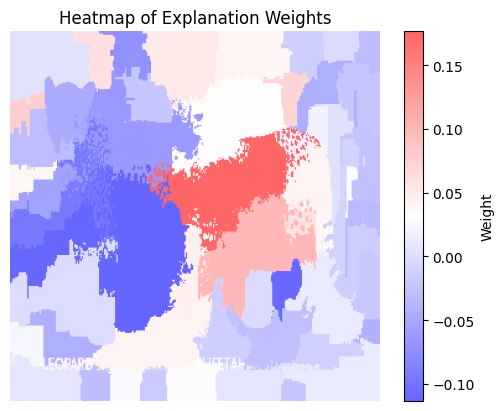

In [13]:
# Generate heatmap for weights of each pixel
labels = explanation.top_labels[0]
weights = explanation.local_exp[labels]
segments = explanation.segments
heatmap = np.zeros(segments.shape)

for index, weight in weights:
  heatmap[segments == index] = weight

plt.imshow(heatmap, cmap='bwr', alpha=0.6)
plt.colorbar(label='Weight')
plt.title('Heatmap of Explanation Weights')
plt.axis('off')
plt.show()

From the heatmap we can see the weights that the model puts on each feature when making it's prediction of a cheetah. We can see that the heaviest weights are on the spotted pattern of the cheetah and we can see that the leopard's pattern has the lightest weight with a negative value. This tells us that our model is able to differentiate between a cheetah and leopard despite their similarities.

LIME took our image and separated into different regions known as superpixels. It then pertubs our images by turning on and off different superpixels. By doing this, we can analyze how the model's predictions are affected by different perturbations. At the end, we can compile all of this and show the importance of each feature for different predictions as shown in the heatmap.